In [8]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [9]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap
from models import JointLatentDiffusionMultilabel, MultilabelClassifier
from datasets import ChestXRay_nih_bbox
import torchvision as tv
from ldm.util import default
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from einops import rearrange, repeat
from ldm.models.diffusion.ddim import DDIMSampler


In [10]:
# config = OmegaConf.load("logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt"

config = OmegaConf.load("logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/configs/config.yaml")
config.model.params["ckpt_path"] = f"logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/checkpoints/last.ckpt"

model = JointLatentDiffusionMultilabel(**config.model.get("params", dict()))
model.sampling_method='conditional_to_x'
model.to("cuda")
model.eval()


JointLatentDiffusionMultilabel: Running in eps-prediction mode
DiffusionWrapper has 402.65 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/logs/compvis32x32x4_all_randomresizedcrop_Autoencoder_2024-01-17T13-15-27/checkpoints/epoch=000025.ckpt
Training JointLatentDiffusionMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/checkpoints/last.ckpt with 0 missing and 0 unexpected keys
WARNING AUROC HARDCODEDDDD to 14 classes


JointLatentDiffusionMultilabel(
  (model): DiffusionWrapper(
    (diffusion_model): AdjustedUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequen

In [11]:
model.sample_grad_scale=40

In [12]:
torch.set_printoptions(sci_mode=False)
config = OmegaConf.load("/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/configs/config.yaml")
ckpt_path = f"/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/checkpoints/last.ckpt"

model_2 = MultilabelClassifier(**config.model.get("params", dict()))
checkpoint = torch.load(ckpt_path)
model_2.load_state_dict(checkpoint["state_dict"])
model_2.to("cuda")
model_2.eval()

MultilabelClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def embed_imgs(model, data_loader, max_samples=100000):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list, bbox_list, label_list = [], [], [], []

    for imgs, bbox, label in tqdm(data_loader):
        if len(imgs.shape) == 3:
            imgs = imgs[..., None]
        imgs = rearrange(imgs, 'b h w c -> b c h w')

        with torch.no_grad():
            encoder_posterior = model.encode_first_stage(imgs.to(device))
            latent = model.get_first_stage_encoding(encoder_posterior).detach()
            img_list.append(imgs.cpu())
            embed_list.append(latent.cpu())
            bbox_list.append(bbox)
            label_list.append(label)
        if max_samples is not None and len(img_list) > max_samples:
            break
    return (img_list, embed_list, bbox_list, label_list)

In [14]:
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
cl_list_loop=cl_list.copy()
T = 10
num_timesteps = 1000
   


In [15]:
for class_ in cl_list_loop:
    dataset = ChestXRay_nih_bbox(pick_class=class_)
    if len(dataset)>0:
        print(class_, 'has N samples: ', len(dataset))
        dl = torch.utils.data.DataLoader(dataset, batch_size=min(len(dataset), 32), shuffle=False)

        ret = embed_imgs(model, dl)
        batch = 0
        x_samples_save = []
        img_original_save = []
        pred_o_save = []
        pred_o_ext_save = []
        pred_ext_save = []
        bbox_save = []


        for img_original, z, bbox in zip(ret[0], ret[1], ret[2]):
            # denoise samples
            z = z.to("cuda")
            t = repeat(torch.tensor([T]), '1 -> b', b=len(z))
            t = t.to("cuda").long()
            noise = torch.randn_like(z)
            z_noisy = model.q_sample(x_start=z, t=t, noise=noise)
            shape = z_noisy.shape            
            samples, pred_o = model.p_sample_loop(cond=None, shape = shape, original_img = z, 
                                                return_intermediates=False, x_T=z_noisy, start_T=T, 
                                                pick_class=class_, return_pred_o=True)
            x_samples = model.decode_first_stage(samples)
            
            #predictions with external clasisfier
            img_original = img_original.to("cuda")
            pred_o_ext = model_2(img_original)
            pred_ext = model_2(x_samples)

            x_samples_save.append(x_samples.detach().cpu().clone())
            del x_samples
            img_original_save.append(img_original.detach().cpu().clone())
            del img_original
            pred_o_save.append(pred_o.detach().cpu().clone())
            del pred_o
            pred_o_ext_save.append(pred_o_ext.detach().cpu().clone())
            del pred_o_ext
            pred_ext_save.append(pred_ext.detach().cpu().clone())
            del pred_ext
            bbox_save.append(bbox.clone())
            del bbox


            batch+=1
            if batch>1000:
                break
            
        folder_to_save = "vce_results_2"
        torch.save(torch.cat(x_samples_save, dim=0), f'{folder_to_save}/T{T}_{class_}_x_samples.pt')
        del x_samples_save
        torch.save(torch.cat(img_original_save, dim=0), f'{folder_to_save}/T{T}_{class_}_img_original.pt')
        del img_original_save
        torch.save(torch.cat(pred_o_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_o.pt')
        del pred_o_save
        torch.save(torch.cat(pred_o_ext_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_o_ext.pt')
        del pred_o_ext_save
        torch.save(torch.cat(pred_ext_save, dim=0), f'{folder_to_save}/T{T}_{class_}_pred_ext.pt')
        del pred_ext_save
        torch.save(torch.cat(bbox_save, dim=0), f'{folder_to_save}/T{T}_{class_}_bbox.pt')
        del bbox_save

Atelectasis has N samples:  180


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Cardiomegaly has N samples:  146


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Effusion has N samples:  153


100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Mass has N samples:  85


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Nodule has N samples:  79


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Pneumonia has N samples:  120


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
Pneumothorax has N samples:  98


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']
[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']


PLOT IMGS

In [10]:
import torch
T = 500
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]

for class_ in cl_list[1:2]:
    x_samples =torch.load(f'vce_results_baseline/T{T}_{class_}_x_samples.pt')
    pred_o = torch.load(f'vce_results_baseline/T{T}_{class_}_pred_o.pt')
    img_original = torch.load(f'vce_results_baseline/T{T}_{class_}_img_original.pt')
    pred_o_ext = torch.load(f'vce_results_baseline/T{T}_{class_}_pred_o_ext.pt')
    pred_ext = torch.load(f'vce_results_baseline/T{T}_{class_}_pred_ext.pt')
    bbox = torch.load(f'vce_results_baseline/T{T}_{class_}_bbox.pt')



In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


all predictins for orig x tensor([0.0801, 0.8547, 0.0307, 0.0136, 0.2049, 0.0316, 0.0245, 0.0090, 0.1731,
        0.0274, 0.0336, 0.0405, 0.0152, 0.0375, 0.2847])
all predictins for x pred start tensor([0.0346, 0.0232, 0.0149, 0.0042, 0.0272, 0.0056, 0.0093, 0.0013, 0.2782,
        0.0095, 0.0285, 0.0109, 0.0094, 0.0145, 0.5861])
predicitons for x original, only class Cardiomegaly tensor(0.8547)
predicitons for x pred start, only class Cardiomegaly tensor(0.0232)


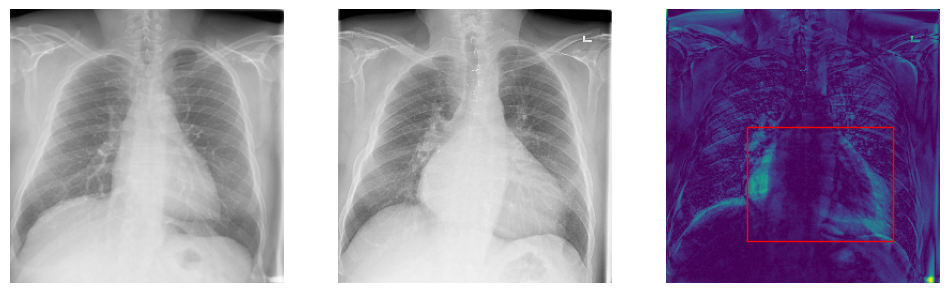

In [13]:
idx_from_batch = 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# Plot the images on the subplots
denoised_guided_normalized = x_samples.cpu()[idx_from_batch].permute(1,2,0)
denoised_guided = denoised_guided_normalized*0.5+0.5
img_ref_normalized = img_original.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_ref_normalized*0.5+0.5
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the plot
axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')

#fig.suptitle(ret[3][0][idx_from_batch])

pred_o_ext_for_item = torch.nn.functional.sigmoid(pred_o_ext[idx_from_batch])
pred_ext_for_item = torch.nn.functional.sigmoid(pred_ext[idx_from_batch])
id_class = cl_list.index(class_)
print('all predictins for orig x', pred_o_ext_for_item)
print('all predictins for x pred start', pred_ext_for_item)
print(f'predicitons for x original, only class {cl_list[id_class]}', pred_o_ext_for_item[id_class])
print(f'predicitons for x pred start, only class {cl_list[id_class]}',pred_ext_for_item[id_class])

